# Preamble

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import scipy
import scipy.sparse as sp
from discretization import create_discretization_element, create_discretization_mesh
from mesh import create_2d_circle, create_toy_mesh
from scipy.integrate import solve_ivp
from solver import get_n_element_operators
from tqdm import tqdm
import matplotlib.animation as animation
from IPython.display import HTML
import imageio_ffmpeg
import pandas as pd
import seaborn as sns

%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams["animation.ffmpeg_path"] = imageio_ffmpeg.get_ffmpeg_exe()

sns.set_theme(style="whitegrid", context="paper")

# Analysis

In [3]:
x_0, y_0 = -0.75, -0.25
sigma = 0.1

# JK: Change from np.pi*t/2 to 2πt
def get_hill_center(t, x_0 = x_0, y_0 = y_0):
    x_t = x_0 * np.cos(2 * np.pi*t) + y_0 * np.sin(2 * np.pi*t)
    y_t = -x_0 * np.sin(2 * np.pi*t) + y_0 * np.cos(2 * np.pi*t)
    return x_t, y_t

def u_exact_hill(x, y, t, sigma = sigma):
    x_center_t, y_center_t = get_hill_center(t)
    return np.exp(-((x - x_center_t)**2 + (y - y_center_t)**2)/(2*sigma**2))

def f_rhs_hill(x, y, t, sigma = sigma):
    return 0

def u_exact_hill_dt(x, y, t, sigma=sigma):
    """
    Time derivative ∂_t u_exact_hill(x,y,t).
    u(x,y,t) = exp(-((x-xc)^2 + (y-yc)^2)/(2*sigma^2)),
    center (xc,yc) rotates with angular speed ω = π/2:
      xc' = ω * yc,   yc' = -ω * xc
    ∂_t u = u * [ (x-xc) xc' + (y-yc) yc' ] / sigma^2
    """
    xc, yc = get_hill_center(t)
    omega = 2 * np.pi
    xc_t = omega * yc
    yc_t = -omega * xc
    u = u_exact_hill(x, y, t, sigma=sigma)
    return u * ((x - xc) * xc_t + (y - yc) * yc_t) / (sigma**2)

def advection_velocity_field(x, y):
    return (2 * np.pi * y, -2 * np.pi * x)

def get_boundary_normal(x, y):
    norm = np.sqrt(x**2 + y**2)
    return x / norm, y / norm

t_array = np.linspace(0, 10, 1000)
x_center_t, y_center_t = get_hill_center(t_array)

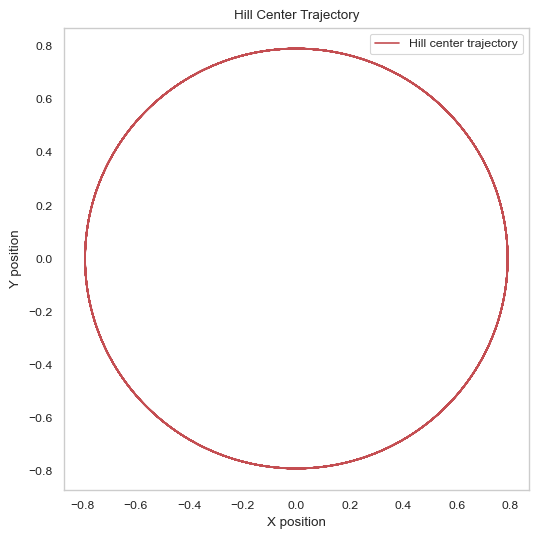

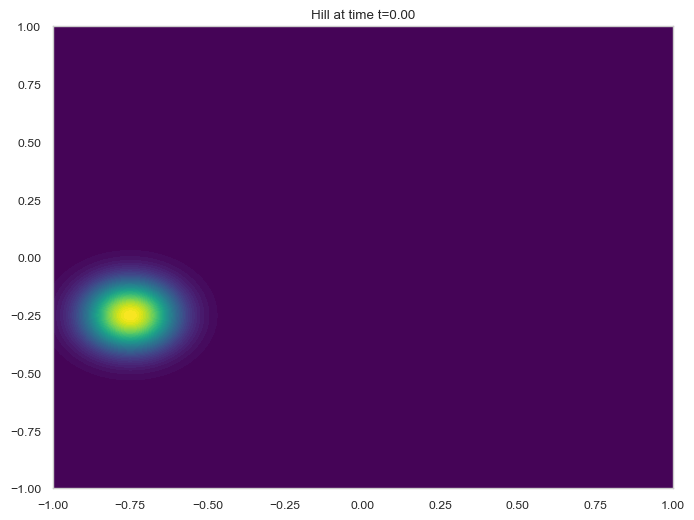

In [4]:
# Show hill center
plt.figure(figsize=(6,6))
plt.plot(x_center_t, y_center_t, 'r-', label='Hill center trajectory')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.title('Hill Center Trajectory')
plt.legend()
plt.grid()
plt.show()

# Show entire hill, just use square domain for simplicity

# x = np.linspace(-1, 1, 200)
# y = np.linspace(-1, 1, 200)
# X, Y = np.meshgrid(x, y)
# t_sample = 10.0
# U = u_exact_hill(X, Y, t_sample)
# plt.figure(figsize=(8,6))
# plt.contourf(X, Y, U, levels=50, cmap='viridis')

# Show animation


fig, ax = plt.subplots(figsize=(8,6))
x = np.linspace(-1, 1, 200)
y = np.linspace(-1, 1, 200)
X, Y = np.meshgrid(x, y)
t_array = np.linspace(0, 1, 100)

def animate_hill(t):  # Changed parameter name from t_array to t
    U = u_exact_hill(X, Y, t)
    ax.clear()
    cont = ax.contourf(X, Y, U, levels=50, cmap='viridis')
    ax.set_title(f'Hill at time t={t:.2f}')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    return cont

ani = animation.FuncAnimation(fig, animate_hill, frames=t_array, interval=100)
# ani.show()
HTML(ani.to_jshtml())


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


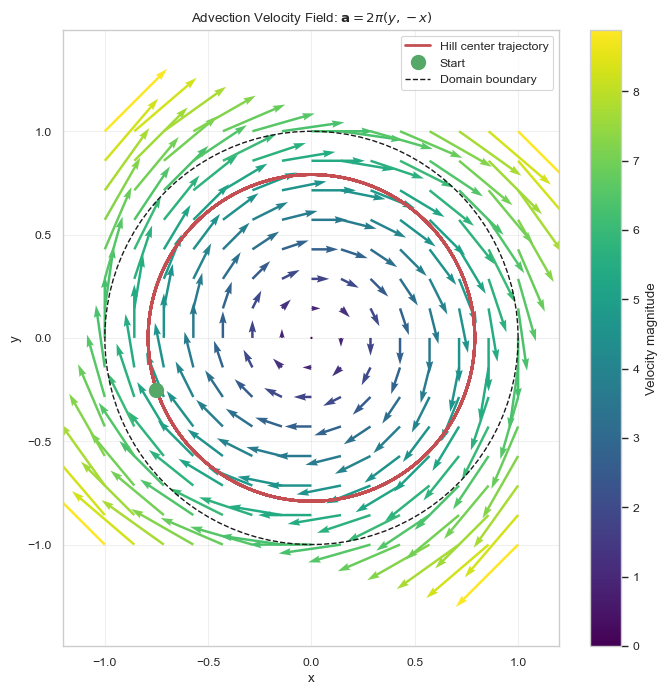

In [5]:
# Plot velocity field on a grid
plt.figure(figsize=(8, 8))

# Create a grid for the velocity field
x_grid = np.linspace(-1, 1, 15)
y_grid = np.linspace(-1, 1, 15)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

# Get velocity at each grid point
U, V = advection_velocity_field(X_grid, Y_grid)

# Plot velocity field with arrows
plt.quiver(X_grid, Y_grid, U, V, np.sqrt(U**2 + V**2),
           cmap='viridis', scale=50, width=0.005)
plt.colorbar(label='Velocity magnitude')

# Add hill center trajectory
plt.plot(x_center_t, y_center_t, 'r-', linewidth=2, label='Hill center trajectory')
plt.plot(x_center_t[0], y_center_t[0], 'go', markersize=10, label='Start')

# Add unit circle boundary
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), 'k--', linewidth=1, label='Domain boundary')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Advection Velocity Field: $\\mathbf{a} = 2\\pi(y, -x)$')
plt.axis('equal')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


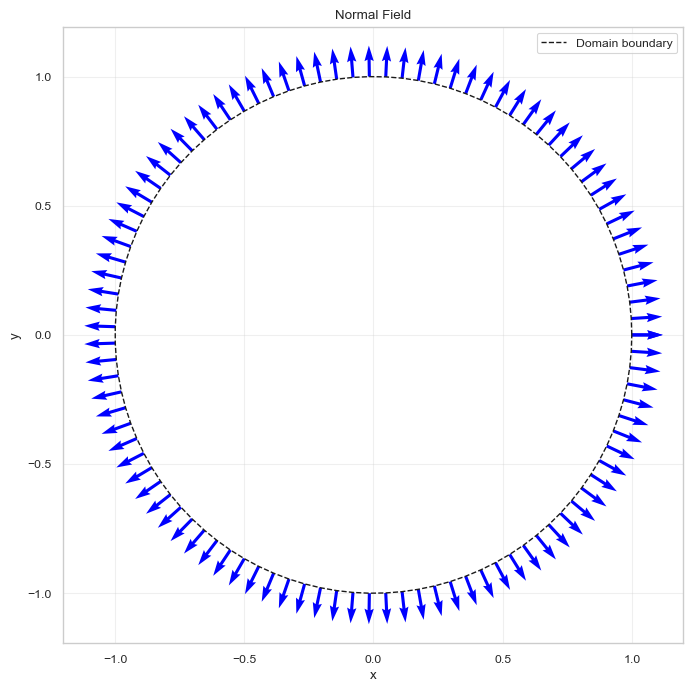

In [6]:
# Plot normal field
plt.figure(figsize=(8, 8))
# Create points on the boundary (unit circle)
theta = np.linspace(0, 2*np.pi, 100)
x_boundary = np.cos(theta)
y_boundary = np.sin(theta)
nx, ny = get_boundary_normal(x_boundary, y_boundary)
plt.quiver(x_boundary, y_boundary, nx, ny, color='blue', scale=20, width=0.005)
plt.plot(x_boundary, y_boundary, 'k--', linewidth=1, label='Domain boundary')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Normal Field')
plt.axis('equal')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Check that normal is unit
assert np.allclose(1.0, np.linalg.norm(np.stack((nx, ny)), axis=0))  # Should be all ones

In [7]:
nx_boundary = nx
ny_boundary = ny
ax_boundary, ay_boundary = advection_velocity_field(x_boundary, y_boundary)

n_boundary = np.stack((nx_boundary, ny_boundary), axis=1)
a_boundary = np.stack((ax_boundary, ay_boundary), axis=1)

a_n_boundary = np.einsum('ij,ij->i', a_boundary, n_boundary)
np.allclose(a_n_boundary, 0)

True

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


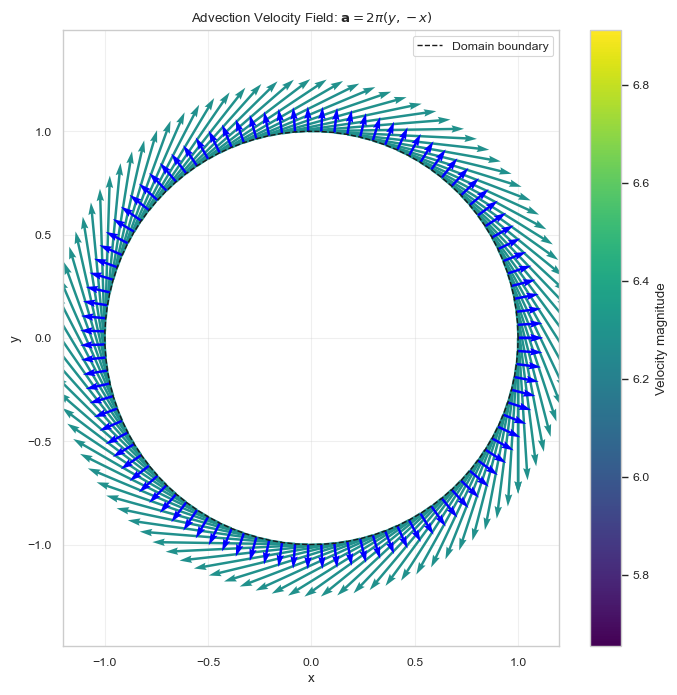

In [8]:
# Plot velocity field on a grid
plt.figure(figsize=(8, 8))

# Get velocity at each grid point
U, V = advection_velocity_field(x_boundary, y_boundary)

# Plot velocity field with arrows
plt.quiver(x_boundary, y_boundary, U, V, np.sqrt(U**2 + V**2),
           cmap='viridis', scale=20, width=0.005)
plt.colorbar(label='Velocity magnitude')
plt.quiver(x_boundary, y_boundary, nx, ny, color='blue', scale=20, width=0.005)

# Add unit circle boundary
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), 'k--', linewidth=1, label='Domain boundary')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Advection Velocity Field: $\\mathbf{a} = 2\\pi(y, -x)$')
plt.axis('equal')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### One element

In [9]:
# Problem parameters
N = 20  # Number of nodes per element
DOMAIN_RADIUS = 1.0
DOMAIN_ORIGIN = (0.0, 0.0)
# MESH_SIZE = 100  # Target mesh size
MESH_SIZE = 0.2

# Create circle mesh
mesh_2d_circle = create_2d_circle(radius=DOMAIN_RADIUS, origin=DOMAIN_ORIGIN, mesh_size=MESH_SIZE)
K = mesh_2d_circle.num_elements

discretisation_element = create_discretization_element(N=N)
discretisation_mesh = create_discretization_mesh(mesh_2d_circle, discretisation_element)

In [10]:
V_x = np.array([-1, 1, -1])
V_y = np.array([-1, 1, 1])
EtoV = np.array([[0, 1, 2]])
mesh_hill_1 = create_toy_mesh(V_x, V_y, EtoV)

N = 20
discretization_element_hill_1 = create_discretization_element(N = N, LocalReorder = np.arange((N+1)*(N+2)//2))
discretization_mesh_hill_1 = create_discretization_mesh(mesh = mesh_hill_1, discretization_element = discretization_element_hill_1)

r, s = discretization_element_hill_1.r, discretization_element_hill_1.s
x_global, y_global = discretization_mesh_hill_1.x_global, discretization_mesh_hill_1.y_global
print(f"{x_global.shape = }")

x_global.shape = (231,)


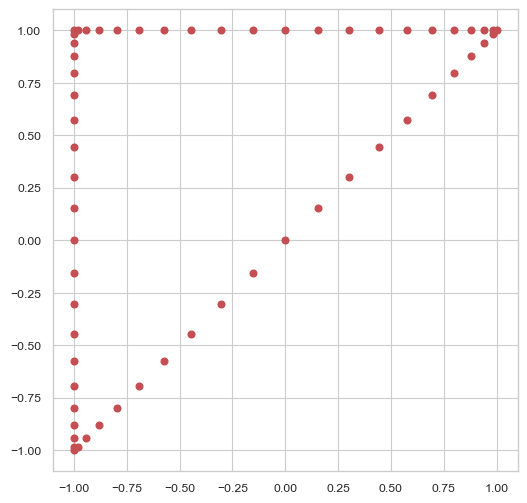

In [11]:
BC_nodes = discretization_mesh_hill_1.BC_nodes
x_boundary = x_global[BC_nodes]
y_boundary = y_global[BC_nodes]
plt.figure(figsize=(6,6))
plt.plot(x_boundary, y_boundary, 'ro', label='Boundary Nodes')

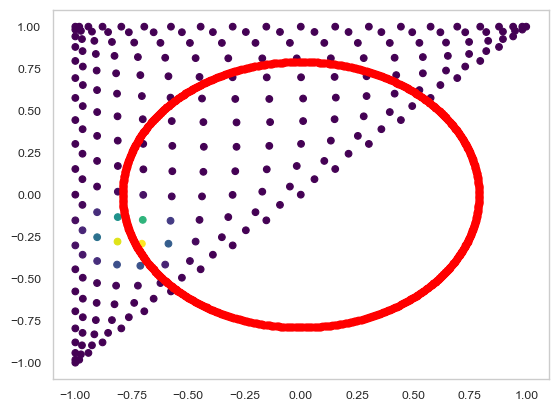

In [12]:
u_true_t = u_exact_hill(x_global, y_global, t=t_array[:, None])
u_0 = u_exact_hill(x_global, y_global, t=0)

plt.scatter(x_global, y_global, c=u_true_t[-1, :], cmap='viridis')
# plt.scatter(x_global, y_global, c=u_0, cmap='viridis')
plt.scatter(x_center_t, y_center_t, color='red')
plt.grid();

# Solver

In [13]:
from scipy.special import gamma

def jacobi_gauss_quadrature(
    N: int, alpha: float, beta: float
) -> tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    """
    Compute N'th order Gauss-Jacobi quadrature nodes x and weights w
    for weight (1-x)^alpha (1+x)^beta on [-1, 1], with alpha,beta > -1.

    Adapted from APEK MATLAB code.
    """
    if N == 0:
        x = np.array([-(alpha - beta) / (alpha + beta + 2.0)], dtype=float)
        w = np.array([2.0], dtype=float)  # matches the provided MATLAB code
        return x, w

    J = np.zeros((N + 1, N + 1), dtype=float)
    k = np.arange(0, N + 1, dtype=float)
    h1 = 2.0 * k + alpha + beta

    J[np.arange(N + 1), np.arange(N + 1)] = (
        -0.5 * (alpha**2 - beta**2) / ((h1 + 2.0) * h1)
    )
    if (alpha + beta) < 10.0 * np.finfo(float).eps:
        J[0, 0] = 0.0  # Legendre limit

    kk = np.arange(1, N + 1, dtype=float)
    b = (
        2.0
        / (h1[:-1] + 2.0)
        * np.sqrt(
            kk
            * (kk + alpha + beta)
            * (kk + alpha)
            * (kk + beta)
            / ((h1[:-1] + 1.0) * (h1[:-1] + 3.0))
        )
    )
    J += np.diag(b, 1)
    J += np.diag(b, -1)
    evals, evecs = np.linalg.eigh(J)
    x = evals  # Gauss nodes
    # Weights from first row of normalized eigenvectors
    # mu0 = integral_{-1}^{1} (1-x)^alpha (1+x)^beta dx
    mu0 = (
        (2.0 ** (alpha + beta + 1.0))
        * gamma(alpha + 1.0)
        * gamma(beta + 1.0)
        / gamma(alpha + beta + 2.0)
    )
    w = mu0 * (evecs[0, :] ** 2)

    idx = np.argsort(x)
    x, w = x[idx], w[idx]

    return x, w


def jacobi_gauss_lobatto(
    N: int, alpha: float, beta: float
) -> tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    """
    Returns the N+1 Gauss-Lobatto nodes for the specified Jacobi polynomial.

    Gauss-Lobatto nodes include the endpoints -1 and 1.
    """
    x = np.zeros(N + 1, dtype=float)
    if N == 1:
        x = np.array([-1, 1])
        w = np.array([1, 1])
        return x, w
    xint, wint = jacobi_gauss_quadrature(N - 2, alpha + 1, beta + 1)
    # FIX: Scale weights by 1/(1-x^2)
    wint = wint / (1.0 - xint**2)
    x = np.concatenate([[-1.0], xint, [1.0]])
    w_boundary = 2.0 / (N * (N + 1))
    w = np.concatenate([[w_boundary], wint, [w_boundary]])
    return x, w


class AdvectionIVPSolver2D:
    def __init__(
        self,
        mesh,
        discretization_element,
        discretization_mesh,
        advection_velocity_field,
        g_bc,
        g_bc_dt,
        f_rhs,
        with_upwind_scheme: bool = True,
    ):
        self.mesh = mesh
        self.discretization_element = discretization_element
        self.discretization_mesh = discretization_mesh
        self.with_upwind_scheme = with_upwind_scheme

        # Advection velocity field, must be stationary
        self.advection_velocity_field = advection_velocity_field

        # Resolve boundary nodes to impose boundary conditions at while respecting upwind scheme
        self.resolved_boundary_nodes = self.resolve_boundary_nodes()

        # These are used for the boundary conditions
        self.g_bc = g_bc  # Boundary Condition u(x,y,t)
        self.g_bc_dt = g_bc_dt  # Time derivative of BC du/dt(x,y,t)

        # This is the source term/RHS without
        self.f_rhs = f_rhs  # Source function f(x,y,t)

        # Assemble constant matrices immediately (since velocity field is stationary)
        self.L_global, self.M_global = self.construct_global_assembly()

        # Apply BCs to get system matrices
        self.M_sys, self.L_sys = self.apply_matrix_bc()

        # Pre-factorize M for efficiency
        self.M_sys_solver = sp.linalg.factorized(self.M_sys.tocsc())


    def resolve_boundary_nodes(self) -> npt.NDArray:
        """
        Identify boundary nodes where the advection velocity points outward.
        These nodes will have their values imposed directly from the boundary condition.
        """
        if not self.with_upwind_scheme:
            return self.discretization_mesh.BC_nodes

        bc_nodes = self.discretization_mesh.BC_nodes
        bc_normals = self.discretization_mesh.BC_normals

        x_global = self.discretization_mesh.x_global
        y_global = self.discretization_mesh.y_global

        a_x, a_y = self.advection_velocity_field(x_global[bc_nodes], y_global[bc_nodes])

        a_n = a_x * bc_normals[:, 0] + a_y * bc_normals[:, 1]

        return bc_nodes[a_n < 0]

    def construct_L_n_element(self, Dx, Dy, M, x_nodes, y_nodes):
        ax, ay = self.advection_velocity_field(x_nodes, y_nodes)

        # Conservative form
        # Strong form advection operator on element: M @ (ax*Dx + ay*Dy)
        # Corresponds to (v, a.grad(u))
        # return M @ (np.diag(ax) @ Dx + np.diag(ay) @ Dy)

        # Split form
        MAx = np.diag(ax) @ M @ Dx
        MAy = np.diag(ay) @ M @ Dy
        return 1/2 * ((MAx - MAx.T) + (MAy - MAy.T))

    def construct_global_assembly(self) -> tuple[npt.NDArray, npt.NDArray]:
        """
        Implementation of Global Assembly based on FEM Book Algorithms 15 & 16.
        Modified for Advection (Non-Symmetric L).
        """
        print("Assembling global matrices...")

        gidx = self.discretization_mesh.gidx

        # Use sparse matrix construction for efficiency
        # We collect triplets (row, col, value)
        L_rows, L_cols, L_vals = [], [], []
        M_rows, M_cols, M_vals = [], [], []

        C = self.discretization_mesh.C
        x_global = self.discretization_mesh.x_global
        y_global = self.discretization_mesh.y_global

        for n_element in tqdm(range(self.mesh.num_elements)):
            # (Assuming get_n_element_operators is available as in your snippet)
            # You might need to pass physical nodes to your operator function if it calculates metrics
            node_indices = C[n_element, :]
            x_nodes = x_global[node_indices]
            y_nodes = y_global[node_indices]

            # Reconstruct vertices for the metric terms if needed by your helper
            # (Assuming your existing helper works as before)
            x_vertex = self.mesh.V_x[self.mesh.EtoV[n_element, :]]
            y_vertex = self.mesh.V_y[self.mesh.EtoV[n_element, :]]
            v1 = np.array([x_vertex[0], y_vertex[0]])
            v2 = np.array([x_vertex[1], y_vertex[1]])
            v3 = np.array([x_vertex[2], y_vertex[2]])

            # Get local operators (Reference Dx, Dy and Metric-scaled M)
            Dx, Dy, M_local, _, _ = get_n_element_operators(
                discretization_element=self.discretization_element,
                v1_n=v1,
                v2_n=v2,
                v3_n=v3,
            )

            # Construct Local Advection Matrix L (Algorithm 15)
            L_local = self.construct_L_n_element(Dx, Dy, M_local, x_nodes, y_nodes)

            # Create meshgrid of indices for this element
            r_idx, c_idx = np.meshgrid(node_indices, node_indices, indexing="ij")

            L_rows.extend(r_idx.flatten())
            L_cols.extend(c_idx.flatten())
            L_vals.extend(L_local.flatten())

            M_rows.extend(r_idx.flatten())
            M_cols.extend(c_idx.flatten())
            M_vals.extend(M_local.flatten())

        # Create Sparse Matrices
        L_global = sp.coo_matrix((L_vals, (L_rows, L_cols)), shape=(gidx, gidx)).tocsr()
        M_global = sp.coo_matrix((M_vals, (M_rows, M_cols)), shape=(gidx, gidx)).tocsr()

        return L_global, M_global

    def apply_matrix_bc(self):
        """
        Modifies M and L to enforce BCs on the system level (Algorithm 17).
        For boundary node i:
          Row i of L_sys becomes 0.
          Row i of M_sys becomes unit row (diagonal=1, others=0).
        Equation becomes: 1 * du_i/dt = RHS_i
        """

        # IMPOSE WEAKLY INSTEAD!
        return self.M_global, self.L_global

    def compute_boundary_flux_term(self, u_current, t):
        """
        Computes the Augmented Flux vector (Numerical Flux integral).
        Implements Equation (16) strictly:
        - Outflow: f* = a_n * u_minus
        - Inflow:  f* = a_n * u_bc
        """
        flux_vector = np.zeros(self.discretization_mesh.gidx)

        # 1D Quadrature weights
        _, w_1d = jacobi_gauss_lobatto(self.discretization_element.N, 0, 0)

        boundary_faces = self.discretization_mesh.BC_faces
        x_global = self.discretization_mesh.x_global
        y_global = self.discretization_mesh.y_global

        for face_nodes in boundary_faces:
            x_f = x_global[face_nodes]
            y_f = y_global[face_nodes]

            dx = x_f[-1] - x_f[0]
            dy = y_f[-1] - y_f[0]
            length = np.sqrt(dx**2 + dy**2)
            J_s = length / 2.0

            nx = self.discretization_mesh.BC_normals[face_nodes[0], 0]
            ny = self.discretization_mesh.BC_normals[face_nodes[0], 1]

            ax, ay = self.advection_velocity_field(x_f, y_f)
            a_n = ax * nx + ay * ny

            u_minus = u_current[face_nodes]
            u_bc = self.g_bc(x_f, y_f, t)

            # Compute Upwind Numerical Flux f*
            f_star = np.where(a_n > 0,
                            a_n * u_minus,
                            a_n * u_bc)

            # Compute Net Penalty Flux for Skew-Symmetric Form
            # net_flux = f_star - 0.5 * (a_n * u_minus)
            net_flux = f_star - a_n * u_minus

            # Integrate
            weighted_flux = net_flux * w_1d * J_s
            flux_vector[face_nodes] += weighted_flux

        return flux_vector

    def get_rhs_IVP(self, t, u):
        """
        Computes du/dt = M^-1 * (-L*u + f - BoundaryTerms)
        """
        x_global = self.discretization_mesh.x_global
        y_global = self.discretization_mesh.y_global

        # Volume term
        rhs = -self.L_global @ u

        # Source term
        if self.f_rhs:
            f_vals = self.f_rhs(x_global, y_global, t)
            rhs += self.M_global @ f_vals

        # Boundary flux
        # We subtract the boundary penalty term
        flux = self.compute_boundary_flux_term(u, t)
        rhs -= flux

        # Solve for du/dt
        du_dt = self.M_sys_solver(rhs)

        return du_dt

In [14]:
# Problem Functions
def get_hill_center(
    t: float, *, x_0: npt.NDArray, y_0: npt.NDArray
) -> tuple[npt.NDArray, npt.NDArray]:
    omega = 2 * np.pi
    x_t = x_0 * np.cos(omega * t) + y_0 * np.sin(omega * t)
    y_t = -x_0 * np.sin(omega * t) + y_0 * np.cos(omega * t)
    return x_t, y_t


def u_exact_hill(x, y, t, *, x_0, y_0, sigma):
    x_center_t, y_center_t = get_hill_center(t, x_0=x_0, y_0=y_0)
    return np.exp(-((x - x_center_t) ** 2 + (y - y_center_t) ** 2) / (2 * sigma**2))


def u_exact_hill_dt(x, y, t, *, x_0, y_0, sigma):
    omega = 2 * np.pi
    xc, yc = get_hill_center(t, x_0=x_0, y_0=y_0)
    xc_t = omega * yc
    yc_t = -omega * xc
    u = u_exact_hill(x, y, t, sigma=sigma, x_0=x_0, y_0=y_0)
    return u * ((x - xc) * xc_t + (y - yc) * yc_t) / (sigma**2)


def f_rhs_hill(x: npt.NDArray, y: npt.NDArray, t: float) -> npt.NDArray:
    return np.zeros_like(x)


def advection_velocity_field(x: npt.NDArray, y: npt.NDArray) -> tuple[npt.NDArray, npt.NDArray]:
    return (2 * np.pi * y, -2 * np.pi * x)

In [15]:
# Solver parameters
N = 5  # Number of nodes per element
DOMAIN_RADIUS = 1.0
DOMAIN_ORIGIN = (0.0, 0.0)
MESH_SIZE = 100  # Target mesh size

# Problem parameters
X_0, Y_0 = -0.5, -0.25
SIGMA = 0.1

t_start = 0.0
t_final = 5.0

mesh = create_2d_circle(radius=1.0, origin=(0.0, 0.0), mesh_size=50)
d_ele = create_discretization_element(N)
d_mesh = create_discretization_mesh(mesh, d_ele)
print(f"Total DOFs: {d_mesh.gidx}")


solver = AdvectionIVPSolver2D(
    mesh=mesh,
    discretization_element=d_ele,
    discretization_mesh=d_mesh,
    advection_velocity_field=advection_velocity_field,
    g_bc=lambda x, y, t: u_exact_hill(x, y, t, sigma=SIGMA, x_0=X_0, y_0=Y_0),
    g_bc_dt=lambda x, y, t: u_exact_hill_dt(x, y, t, sigma=SIGMA, x_0=X_0, y_0=Y_0),
    f_rhs=f_rhs_hill,
    with_upwind_scheme=True,
)

# Set up initial condition
u0 = u_exact_hill(
    d_mesh.x_global, d_mesh.y_global, t=t_start, sigma=SIGMA, x_0=X_0, y_0=Y_0
)

t_span = (t_start, t_final,)
n_frames = 300
t_eval = np.linspace(t_start, t_final, n_frames)

sol = solve_ivp(
    fun=solver.get_rhs_IVP,
    t_span=t_span,
    y0=u0,
    t_eval=t_eval,
    method="RK45",  # Explicit Runge-Kutta order 5(4)
    # rtol=1e-6,  # Relative tolerance
    # atol=1e-9,  # Absolute tolerance
    # rtol=1e-8,  # Relative tolerance
    # atol=1e-11,  # Absolute tolerance
    # max_step=0.0001,  # Limit max step size for accuracy
)

u_sols, t_sols = sol.y.T, sol.t
print(sol.nfev)

Total DOFs: 1521
Assembling global matrices...


100%|██████████| 117/117 [00:00<00:00, 5318.22it/s]


7124


In [16]:
print(solver.resolved_boundary_nodes.shape)
print(d_mesh.BC_nodes.shape)

(47,)
(115,)


[ 1.05619803e-14  6.66133815e-16  1.64313008e-14  1.68753900e-14
 -1.77635684e-15  1.13242749e-14  1.09356968e-14  7.10542736e-15
  3.99680289e-15  1.02140518e-14  1.24344979e-14  3.77475828e-15
  1.11022302e-15  7.99360578e-15  9.76996262e-15  1.06581410e-14
  1.35447209e-14  1.58206781e-14  1.37667655e-14  7.54951657e-15
  1.06581410e-14  1.06581410e-14  1.11022302e-14 -6.54550954e-01
 -2.44032759e-01  2.44032759e-01  6.54550954e-01 -6.54550954e-01
 -2.44032759e-01  2.44032759e-01  6.54550954e-01 -6.54550954e-01
 -2.44032759e-01  2.44032759e-01  6.54550954e-01 -6.54550954e-01
 -2.44032759e-01  2.44032759e-01  6.54550954e-01 -6.54550954e-01
 -2.44032759e-01  2.44032759e-01  6.54550954e-01 -6.54550954e-01
 -2.44032759e-01  2.44032759e-01  6.54550954e-01 -6.54550954e-01
 -2.44032759e-01  2.44032759e-01  6.54550954e-01 -6.54550954e-01
 -2.44032759e-01  2.44032759e-01  6.54550954e-01 -6.54550954e-01
 -2.44032759e-01  2.44032759e-01  6.54550954e-01 -6.54550954e-01
 -2.44032759e-01  2.44032

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

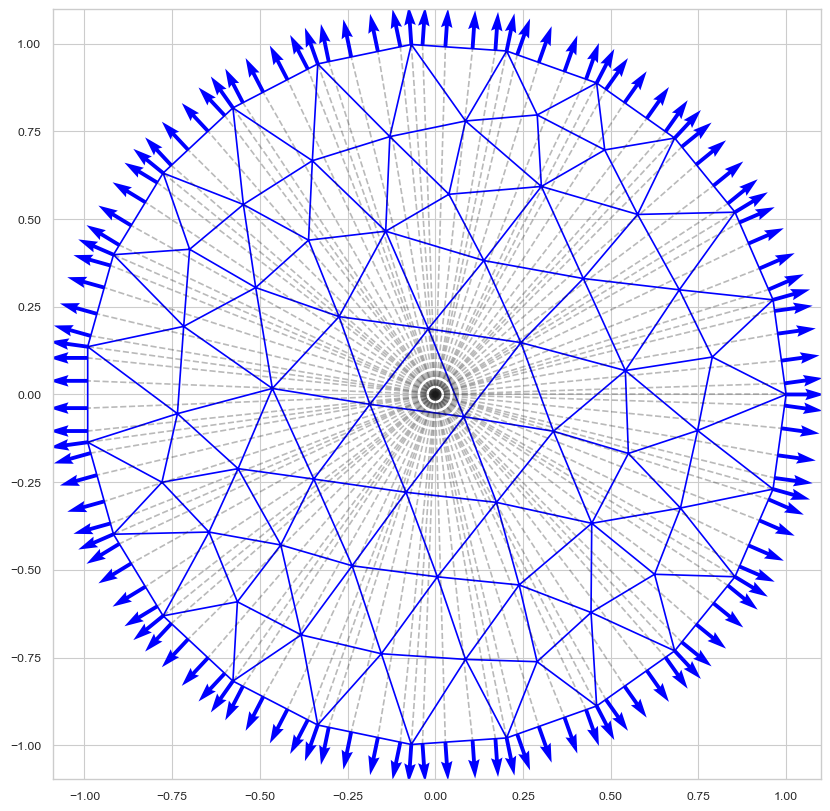

In [17]:
### Upwind and node normal debugging
bc_normals = d_mesh.BC_normals
bc_normals.shape

bc_nodes_x = d_mesh.x_global[d_mesh.BC_nodes]
bc_nodes_y = d_mesh.y_global[d_mesh.BC_nodes]

ax_bc, ay_bc = advection_velocity_field(bc_nodes_x, bc_nodes_y)

a_n = np.einsum('ij,ij->i', np.stack((ax_bc, ay_bc), axis=1), bc_normals)
print(a_n)

plt.figure(figsize=(10, 10))

plt.quiver(
    bc_nodes_x,
    bc_nodes_y,
    bc_normals[:, 0],
    bc_normals[:, 1],
    color="blue",
    scale=20,
    width=0.005,
    label="Boundary Normals",
)

# Plot conneections between bc nodes
for i in range(len(bc_nodes_x)):
    plt.plot(
        [0, bc_nodes_x[i]],
        [0, bc_nodes_y[i]],
        "k--",
        alpha=0.3,
    )

plt.gca().set_aspect('equal')

# Plot mesh
mesh.plot(plt.gca())

np.linalg.norm(bc_normals, axis=1)

In [18]:
# N = 7 # Number of nodes per element
# DOMAIN_RADIUS = 1.0
# DOMAIN_ORIGIN = (0.0, 0.0)
# MESH_SIZE = 100  # Target mesh size

# mm = 1/25.4 # inverse millimeters in inches
# FIG_SIZE = 240 * mm

# # Problem parameters
# X_0, Y_0 = -0.75, -0.25
# SIGMA = 0.1

# t_start = 0.0
# t_final = 5.0

# mesh = create_2d_circle(radius=1.0, origin=(0.0, 0.0), mesh_size=100)
# d_ele = create_discretization_element(N)
# d_mesh = create_discretization_mesh(mesh, d_ele)
# print(f"Total DOFs: {d_mesh.gidx}")

# bc_normals = d_mesh.BC_normals
# bc_normals.shape

# bc_nodes_x = d_mesh.x_global[d_mesh.BC_nodes]
# bc_nodes_y = d_mesh.y_global[d_mesh.BC_nodes]

# ax_bc, ay_bc = advection_velocity_field(bc_nodes_x, bc_nodes_y)

# a_n = np.einsum('ij,ij->i', np.stack((ax_bc, ay_bc), axis=1), bc_normals)

# plt.figure(figsize=(FIG_SIZE, FIG_SIZE))

# plt.quiver(
#     bc_nodes_x,
#     bc_nodes_y,
#     bc_normals[:, 0],
#     bc_normals[:, 1],
#     color="tab:red",
#     scale=20,
#     width=0.005,
#     label="Boundary Normals",
# )

# plt.scatter(
#     d_mesh.x_global,
#     d_mesh.y_global,
#     s=10,
# )


# plt.gca().set_aspect('equal')

# # Plot mesh
# mesh.plot(plt.gca())

# # plt.grid(False)
# plt.xticks([])
# plt.yticks([])
# plt.gca().set_frame_on(False)

# plt.savefig("report/output/boundary_normals", dpi=1200, bbox_inches="tight")

<Axes: xlabel='time', ylabel='energy'>

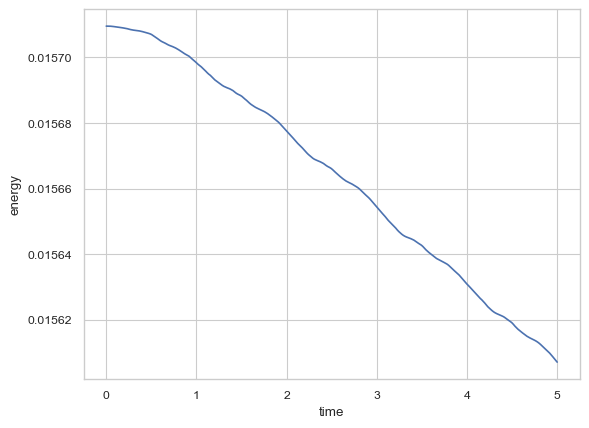

In [19]:
data = []
# Compute energy over time
for u, t in zip(u_sols, t_sols):
    energy = 0.5 * (u @ (solver.M_global @ u))
    data.append({
        "energy": energy,
        "time": t
    })
df = pd.DataFrame(data)

# Plot energy
plt.figure()
sns.lineplot(data=df, x="time", y="energy")


Computing Error...
L2 Error at t=5.0: 1.00e-02


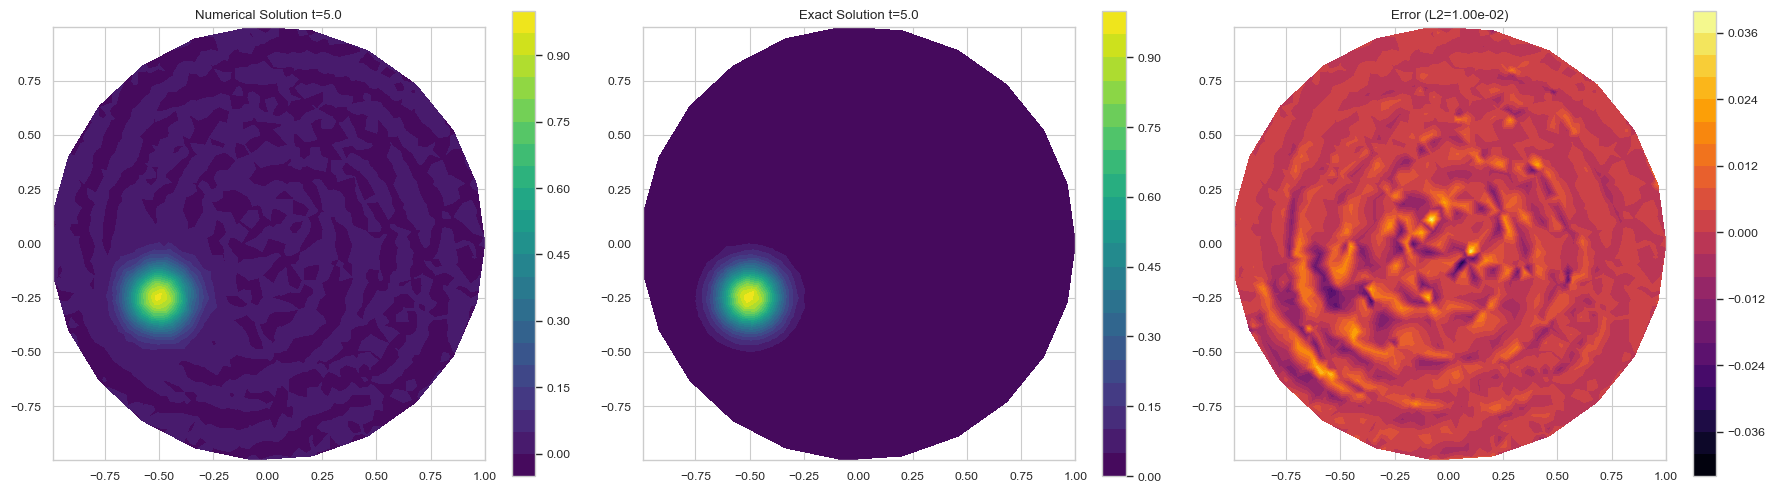

In [20]:


# Compute Error
print("Computing Error...")
final_sol = u_sols[-1]
exact_sol = u_exact_hill(d_mesh.x_global, d_mesh.y_global, t=t_final, sigma=SIGMA, x_0=X_0, y_0=Y_0)
error = final_sol - exact_sol
L2_err = np.sqrt(error @ (solver.M_global @ error))
print(f"L2 Error at t={t_final}: {L2_err:.2e}")

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Triangulation for plotting
triang = mpl.tri.Triangulation(d_mesh.x_global, d_mesh.y_global)

# Solution
tc1 = axs[0].tricontourf(triang, final_sol, levels=20, cmap="viridis")
fig.colorbar(tc1, ax=axs[0])
axs[0].set_title(f"Numerical Solution t={t_final}")
axs[0].set_aspect("equal")

# Exact
tc2 = axs[1].tricontourf(triang, exact_sol, levels=20, cmap="viridis")
fig.colorbar(tc2, ax=axs[1])
axs[1].set_title(f"Exact Solution t={t_final}")
axs[1].set_aspect("equal")

# Error
tc3 = axs[2].tricontourf(triang, error, levels=20, cmap="inferno")
fig.colorbar(tc3, ax=axs[2])
axs[2].set_title(f"Error (L2={L2_err:.2e})")
axs[2].set_aspect("equal")

plt.tight_layout()
# plt.savefig("solution_plot.png")
# print("Plot saved.")



# Video

In [21]:
# n_frames = 60
# t_eval_points = np.linspace(t_start, t_final, n_frames)

# print(f"Resolving IVP for animation with {n_frames} frames...")

# u_anim = sol.y.T  # Shape: (n_frames, n_dofs)
# t_anim = sol.t

# # Pre-compute limits for stable colormaps
# # Solution limits
# u_min, u_max = np.min(u_anim), np.max(u_anim)

# # Error limits (We need to compute exact solution for all frames first)
# # This prevents the error plot from flashing wildly at t=0 when error is near zero
# print("Pre-calculating error bounds...")
# all_exact = np.array(
#     [
#         u_exact_hill(d_mesh.x_global, d_mesh.y_global, t, sigma=SIGMA, x_0=X_0, y_0=Y_0)
#         for t in t_anim
#     ]
# )
# all_error = u_anim - all_exact
# err_min, err_max = np.min(all_error), np.max(all_error)
# # Center error colormap around 0 for better visualization of over/undershoot
# err_abs_max = max(abs(err_min), abs(err_max))

# # Setup Plotting Environment
# fig, axs = plt.subplots(1, 3, figsize=(20, 6))
# triang = mpl.tri.Triangulation(d_mesh.x_global, d_mesh.y_global)


# def update(frame):
#     # Clear previous frame's contours
#     for ax in axs:
#         ax.clear()
#         ax.set_aspect("equal")
#         ax.set_xlim(-DOMAIN_RADIUS, DOMAIN_RADIUS)
#         ax.set_ylim(-DOMAIN_RADIUS, DOMAIN_RADIUS)

#     current_t = t_anim[frame]
#     current_u = u_anim[frame]
#     current_exact = all_exact[frame]
#     current_error = all_error[frame]

#     # --- Plot Numerical Solution ---
#     # using vmin/vmax locks the color scale so the wave creates contrast against the background
#     tc1 = axs[0].tricontourf(
#         triang, current_u, levels=20, cmap="viridis", vmin=u_min, vmax=u_max
#     )
#     axs[0].set_title(f"Numerical: t={current_t:.3f}")

#     # --- Plot Exact Solution ---
#     tc2 = axs[1].tricontourf(
#         triang, current_exact, levels=20, cmap="viridis", vmin=u_min, vmax=u_max
#     )
#     axs[1].set_title(f"Exact: t={current_t:.3f}")

#     # --- Plot Error ---
#     # using 'seismic' or 'coolwarm' is better for error to distinguish positive/negative deviation
#     tc3 = axs[2].tricontourf(
#         triang,
#         current_error,
#         levels=20,
#         cmap="seismic",
#         vmin=-err_abs_max,
#         vmax=err_abs_max,
#     )
#     axs[2].set_title(f"Error (Num - Exact)")

#     return axs


# # Add Colorbars (Static)
# # Solution Colorbar (for plots 1 and 2)
# sm_sol = plt.cm.ScalarMappable(
#     cmap="viridis", norm=plt.Normalize(vmin=u_min, vmax=u_max)
# )
# sm_sol.set_array([])
# cbar1 = fig.colorbar(sm_sol, ax=axs[:2].ravel().tolist(), shrink=0.9, pad=0.05)
# cbar1.set_label("u(x,y)")

# # Error Colorbar (for plot 3)
# sm_err = plt.cm.ScalarMappable(
#     cmap="seismic", norm=plt.Normalize(vmin=-err_abs_max, vmax=err_abs_max)
# )
# sm_err.set_array([])
# cbar2 = fig.colorbar(sm_err, ax=axs[2], shrink=0.9, pad=0.05)
# cbar2.set_label("Error")

# # Create Animation
# anim = animation.FuncAnimation(fig, update, frames=len(t_anim), interval=100)

# plt.close()  # Prevent static display

# # Display
# HTML(anim.to_jshtml())
# # To save as MP4:
# # anim.save("advection_sim.mp4", fps=15)

In [22]:
last_sol = sol.y.T[-1]
last_t = sol.t[-1]
solver.discretization_mesh.BC_nodes
u_boundary = last_sol[solver.discretization_mesh.BC_nodes]
u_exact = u_exact_hill(
    solver.discretization_mesh.x_global,
    solver.discretization_mesh.y_global,
    t=last_t,
    sigma=SIGMA,
    x_0=X_0,
    y_0=Y_0,
)

u_exact_boundary = u_exact[solver.discretization_mesh.BC_nodes]

u_exact_boundary - u_boundary

array([-3.27951650e-03, -1.16243009e-02,  4.86593014e-03, -4.20604140e-03,
       -7.04698144e-04,  1.13693251e-02, -5.98799991e-04,  2.16687092e-03,
       -3.33923476e-03,  4.67049750e-04, -2.58165131e-03,  7.39156915e-04,
       -6.61813905e-03,  1.49617027e-02,  2.01022001e-03, -3.17565547e-03,
        4.23842839e-03, -7.51376107e-03, -6.23404607e-03, -1.41400369e-03,
        2.27834128e-03,  2.93884377e-03, -4.77506878e-03,  1.90216198e-03,
       -4.80067184e-04, -2.07741545e-04, -2.95666977e-03, -4.54425975e-03,
        1.30458644e-03,  3.45743030e-03,  6.07809787e-03,  3.12142226e-04,
       -6.64164682e-04,  1.23229689e-03,  4.54113923e-03,  1.02311487e-03,
       -8.71063715e-04,  2.26523309e-04, -2.95127765e-03, -1.04673627e-03,
        1.06066245e-03, -3.92607098e-04,  4.76249904e-03, -7.71265669e-04,
       -6.23112063e-05,  3.53546048e-04,  2.99264378e-03, -4.74007795e-03,
        2.18329660e-03,  2.41404214e-03,  1.09527093e-03, -6.33761895e-04,
       -7.65373250e-04,  

# Convergence

In [23]:
# Solver parameters
N = 5  # Number of nodes per element
DOMAIN_RADIUS = 1.0
DOMAIN_ORIGIN = (0.0, 0.0)
MESH_SIZE = 100  # Target mesh size

# Problem parameters
X_0, Y_0 = -0.75, -0.25
SIGMA = 0.1

t_start = 0.0
t_final = 1.0


for mesh_size in np.linspace(0.20, 0.29, 5):
    mesh = create_2d_circle(radius=1.0, origin=(0.0, 0.0), mesh_size=mesh_size)
    print(f"K: {mesh.num_elements}, {mesh_size=}")


K: 212, mesh_size=np.float64(0.2)
K: 173, mesh_size=np.float64(0.2225)
K: 146, mesh_size=np.float64(0.245)
K: 122, mesh_size=np.float64(0.26749999999999996)
K: 117, mesh_size=np.float64(0.29)


In [24]:
import itertools
import time


Ns = np.arange(2, 9)
# mesh_sizes = np.linspace(0.15, 0.29, 8)
mesh_sizes = np.linspace(0.20, 0.29, 5)

convergence_data = []
for N, mesh_size in tqdm(itertools.product(Ns, mesh_sizes)):
    print(f"Running simulation for N={N}, mesh_size={mesh_size}...")
    mesh = create_2d_circle(radius=1.0, origin=(0.0, 0.0), mesh_size=mesh_size)
    d_ele = create_discretization_element(N)
    d_mesh = create_discretization_mesh(mesh, d_ele)

    solver = AdvectionIVPSolver2D(
        mesh=mesh,
        discretization_element=d_ele,
        discretization_mesh=d_mesh,
        advection_velocity_field=advection_velocity_field,
        g_bc=lambda x, y, t: u_exact_hill(x, y, t, sigma=SIGMA, x_0=X_0, y_0=Y_0),
        g_bc_dt=lambda x, y, t: u_exact_hill_dt(x, y, t, sigma=SIGMA, x_0=X_0, y_0=Y_0),
        f_rhs=f_rhs_hill,
    )

    u0 = u_exact_hill(
        d_mesh.x_global, d_mesh.y_global, t=t_start, sigma=SIGMA, x_0=X_0, y_0=Y_0
    )

    t_span = (t_start, t_final)
    t_eval = [t_final]

    t_cpu_start = time.perf_counter()
    sol = solve_ivp(
        fun=solver.get_rhs_IVP,
        t_span=t_span,
        y0=u0,
        # t_eval=t_eval,
        method="RK45",
        # rtol=1e-6,
        # atol=1e-9,
    )
    t_cpu_total = time.perf_counter() - t_cpu_start

    if not sol.success:
        print("Solver failed!")
        continue

    final_sol = sol.y.T[-1]
    exact_sol = u_exact_hill(d_mesh.x_global, d_mesh.y_global, t=t_final, sigma=SIGMA, x_0=X_0, y_0=Y_0)
    error = final_sol - exact_sol
    L2_err = np.sqrt(error @ (solver.M_global @ error))
    Linf_err = np.max(np.abs(error))

    convergence_data.append({
        "N": N,
        "mesh_size": mesh_size,
        "K": mesh.num_elements,
        "L2_error": L2_err,
        "Linf_error": Linf_err,
        "num_elements": mesh.num_elements,
        "sol": final_sol,
        "exact_sol": exact_sol,
        "nfev": sol.nfev,
        "time_total": t_cpu_total,
    })


0it [00:00, ?it/s]

Running simulation for N=2, mesh_size=0.2...
Assembling global matrices...


100%|██████████| 212/212 [00:00<00:00, 2806.15it/s]
1it [00:00,  1.61it/s]

Running simulation for N=2, mesh_size=0.2225...
Assembling global matrices...


100%|██████████| 173/173 [00:00<00:00, 11183.95it/s]
2it [00:01,  1.72it/s]

Running simulation for N=2, mesh_size=0.245...
Assembling global matrices...


100%|██████████| 146/146 [00:00<00:00, 5590.36it/s]
3it [00:01,  1.85it/s]

Running simulation for N=2, mesh_size=0.26749999999999996...
Assembling global matrices...


100%|██████████| 122/122 [00:00<00:00, 10355.26it/s]
4it [00:02,  2.05it/s]

Running simulation for N=2, mesh_size=0.29...
Assembling global matrices...


100%|██████████| 117/117 [00:00<00:00, 9928.45it/s]
5it [00:02,  2.26it/s]

Running simulation for N=3, mesh_size=0.2...
Assembling global matrices...


100%|██████████| 212/212 [00:00<00:00, 8901.00it/s]
6it [00:03,  1.61it/s]

Running simulation for N=3, mesh_size=0.2225...
Assembling global matrices...


100%|██████████| 173/173 [00:00<00:00, 10750.16it/s]
7it [00:04,  1.56it/s]

Running simulation for N=3, mesh_size=0.245...
Assembling global matrices...


100%|██████████| 146/146 [00:00<00:00, 9389.85it/s]
8it [00:04,  1.66it/s]

Running simulation for N=3, mesh_size=0.26749999999999996...
Assembling global matrices...


100%|██████████| 122/122 [00:00<00:00, 11008.44it/s]
9it [00:05,  1.78it/s]

Running simulation for N=3, mesh_size=0.29...
Assembling global matrices...


100%|██████████| 117/117 [00:00<00:00, 9747.41it/s]
10it [00:05,  1.65it/s]

Running simulation for N=4, mesh_size=0.2...
Assembling global matrices...


100%|██████████| 212/212 [00:00<00:00, 9398.40it/s]
11it [00:07,  1.06it/s]

Running simulation for N=4, mesh_size=0.2225...
Assembling global matrices...


100%|██████████| 173/173 [00:00<00:00, 7840.58it/s]
12it [00:08,  1.11s/it]

Running simulation for N=4, mesh_size=0.245...
Assembling global matrices...


100%|██████████| 146/146 [00:00<00:00, 6616.55it/s]
13it [00:10,  1.09s/it]

Running simulation for N=4, mesh_size=0.26749999999999996...
Assembling global matrices...


100%|██████████| 122/122 [00:00<00:00, 9335.47it/s]
14it [00:10,  1.03it/s]

Running simulation for N=4, mesh_size=0.29...
Assembling global matrices...


100%|██████████| 117/117 [00:00<00:00, 9647.95it/s]
15it [00:11,  1.15it/s]

Running simulation for N=5, mesh_size=0.2...
Assembling global matrices...


100%|██████████| 212/212 [00:00<00:00, 6315.47it/s]
16it [00:13,  1.32s/it]

Running simulation for N=5, mesh_size=0.2225...
Assembling global matrices...


100%|██████████| 173/173 [00:00<00:00, 5646.23it/s]
17it [00:15,  1.51s/it]

Running simulation for N=5, mesh_size=0.245...
Assembling global matrices...


100%|██████████| 146/146 [00:00<00:00, 5574.94it/s]
18it [00:17,  1.49s/it]

Running simulation for N=5, mesh_size=0.26749999999999996...
Assembling global matrices...


100%|██████████| 122/122 [00:00<00:00, 5189.02it/s]
19it [00:18,  1.42s/it]

Running simulation for N=5, mesh_size=0.29...
Assembling global matrices...


100%|██████████| 117/117 [00:00<00:00, 7476.93it/s]
20it [00:19,  1.35s/it]

Running simulation for N=6, mesh_size=0.2...
Assembling global matrices...


100%|██████████| 212/212 [00:00<00:00, 3779.78it/s]
21it [00:24,  2.55s/it]

Running simulation for N=6, mesh_size=0.2225...
Assembling global matrices...


100%|██████████| 173/173 [00:00<00:00, 4354.62it/s]
22it [00:27,  2.69s/it]

Running simulation for N=6, mesh_size=0.245...
Assembling global matrices...


100%|██████████| 146/146 [00:00<00:00, 3008.93it/s]
23it [00:30,  2.58s/it]

Running simulation for N=6, mesh_size=0.26749999999999996...
Assembling global matrices...


100%|██████████| 122/122 [00:00<00:00, 4777.65it/s]
24it [00:32,  2.35s/it]

Running simulation for N=6, mesh_size=0.29...
Assembling global matrices...


100%|██████████| 117/117 [00:00<00:00, 6122.54it/s]
25it [00:33,  2.15s/it]

Running simulation for N=7, mesh_size=0.2...
Assembling global matrices...


100%|██████████| 212/212 [00:00<00:00, 1157.05it/s]
26it [00:44,  4.65s/it]

Running simulation for N=7, mesh_size=0.2225...
Assembling global matrices...


100%|██████████| 173/173 [00:00<00:00, 2725.98it/s]
27it [00:52,  5.83s/it]

Running simulation for N=7, mesh_size=0.245...
Assembling global matrices...


100%|██████████| 146/146 [00:00<00:00, 1751.91it/s]
28it [01:00,  6.36s/it]

Running simulation for N=7, mesh_size=0.26749999999999996...
Assembling global matrices...


100%|██████████| 122/122 [00:00<00:00, 1972.13it/s]
29it [01:04,  5.78s/it]

Running simulation for N=7, mesh_size=0.29...
Assembling global matrices...


100%|██████████| 117/117 [00:00<00:00, 1928.89it/s]
30it [01:09,  5.39s/it]

Running simulation for N=8, mesh_size=0.2...
Assembling global matrices...


100%|██████████| 212/212 [00:00<00:00, 1242.85it/s]
31it [01:31, 10.45s/it]

Running simulation for N=8, mesh_size=0.2225...
Assembling global matrices...


100%|██████████| 173/173 [00:00<00:00, 1328.88it/s]
32it [01:50, 12.85s/it]

Running simulation for N=8, mesh_size=0.245...
Assembling global matrices...


100%|██████████| 146/146 [00:00<00:00, 1143.87it/s]
33it [02:03, 13.15s/it]

Running simulation for N=8, mesh_size=0.26749999999999996...
Assembling global matrices...


100%|██████████| 122/122 [00:00<00:00, 1328.07it/s]
34it [02:13, 12.07s/it]

Running simulation for N=8, mesh_size=0.29...
Assembling global matrices...


100%|██████████| 117/117 [00:00<00:00, 1701.70it/s]
35it [02:23,  4.11s/it]


[]

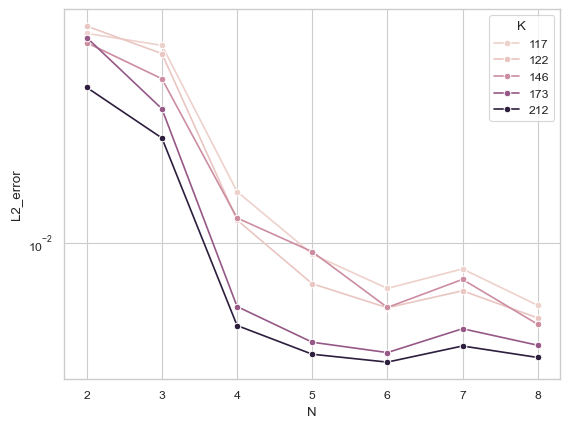

In [27]:
df = pd.DataFrame(convergence_data)
# sns.lineplot(data=df, x="mesh_size", y="L2_error", hue="N", marker="o")
sns.lineplot(data=df, x="N", y="L2_error", hue="K", marker="o")
plt.semilogy()

In [26]:
# Solver parameters
N = 5  # Number of nodes per element
DOMAIN_RADIUS = 1.0
DOMAIN_ORIGIN = (0.0, 0.0)
MESH_SIZE = 100  # Target mesh size

# Problem parameters
X_0, Y_0 = -0.75, -0.25
SIGMA = 0.1

t_start = 0.0
t_final = 1.0

mesh = create_2d_circle(radius=1.0, origin=(0.0, 0.0), mesh_size=50)
d_ele = create_discretization_element(N)
d_mesh = create_discretization_mesh(mesh, d_ele)
print(f"Total DOFs: {d_mesh.gidx}")


solver = AdvectionIVPSolver2D(
    mesh=mesh,
    discretization_element=d_ele,
    discretization_mesh=d_mesh,
    advection_velocity_field=advection_velocity_field,
    g_bc=lambda x, y, t: u_exact_hill(x, y, t, sigma=SIGMA, x_0=X_0, y_0=Y_0),
    g_bc_dt=lambda x, y, t: u_exact_hill_dt(x, y, t, sigma=SIGMA, x_0=X_0, y_0=Y_0),
    f_rhs=f_rhs_hill,
)

# Set up initial condition
u0 = u_exact_hill(
    d_mesh.x_global, d_mesh.y_global, t=t_start, sigma=SIGMA, x_0=X_0, y_0=Y_0
)

t_span = (t_start, t_final,)
n_frames = 60
t_eval = np.linspace(t_start, t_final, n_frames)

sol = solve_ivp(
    fun=solver.get_rhs_IVP,
    t_span=t_span,
    y0=u0,
    t_eval=t_eval,
    method="RK45",  # Explicit Runge-Kutta order 5(4)
    rtol=1e-6,  # Relative tolerance
    atol=1e-9,  # Absolute tolerance
)

u_sols, t_sols = sol.y.T, sol.t

Total DOFs: 1521
Assembling global matrices...


100%|██████████| 117/117 [00:00<00:00, 5196.03it/s]


# TODO

- Upwind flux